# WGCNA Analysis of Genes by Diagnosis

**Created**: 27 October 2021

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

Loading required namespace: patchwork



In [2]:
library(WGCNA)
library(tidyverse)
library(RColorBrewer)
library(patchwork)

options(stringsAsFactors = FALSE)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor


── Attaching packages ────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Load Data

In [3]:
gene.exp <- read.table("/nfs/team282/data/gains_team282/Logcpm_864_20416.txt")
gene.exp <- as.data.frame(t(gene.exp))

sample.info <- read.table("/nfs/team282/data/gains_team282/Sample_info_864.txt")
sample.info <- sample.info %>% 
  dplyr::filter(supplier_name %in% rownames(gene.exp))
rownames(sample.info) <- sample.info$supplier_name
sample.info <- sample.info[rownames(gene.exp),]

outcome <- read.table("/nfs/team282/data/gains_team282/ClinicalData/clinical_data_tsv/OUT_12jun2019.tsv", sep="\t", header=T, quote="")
outcome <- outcome %>%
  dplyr::mutate(GAinSID=stringr::str_to_upper(SubjectBarCode))
outcome <- merge(sample.info, outcome, by="GAinSID", all.x=TRUE)
rownames(outcome) <- outcome$supplier_name
outcome <- outcome[sample.info$supplier_name,]
outcome$diagnosis <- replace(outcome$diagnosis, is.na(outcome$diagnosis), 0)

gene.exp.cap <- gene.exp[outcome$diagnosis == 1,]
gene.exp.fp <- gene.exp[outcome$diagnosis == 2,]

sample.info.cap <- sample.info[outcome$diagnosis == 1,]
sample.info.fp <- sample.info[outcome$diagnosis == 2,]

rm(gene.exp, sample.info)

## CAP Individuals

The following analysis generates co-expression modules from gene expression from individuals with community-acquired pneuomnia (CAP).

### WGCNA Checks

The following function identifies genes with excessive missing values and outlier samples. It is generally more important for microarray data.

In [4]:
gsg <- goodSamplesGenes(gene.exp.cap)
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

### Soft Threshold

The adjacency matrix generated using the correlation function does not fit a scale-free topology. A scaling function is used to generate the appropriate gene degree distribution. A parameter of this scaling function, $\beta$, is estimated by trying multiple values and checking how well the resulting network fits the assumptions of a scale-free network. Here, I try all integer values in $[1,20]$.

In [5]:
powers = seq(1, 20, by=1)

soft.thresholds = pickSoftThreshold(gene.exp.cap, powerVector=powers, networkType="unsigned", corFnc=bicor)

soft.threshold.cap = soft.thresholds$powerEstimate

Warning message:
“executing %dopar% sequentially: no parallel backend registered”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "

   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1    0.146  0.515          0.871 3900.00  3.88e+03 7100.0
2      2    0.477 -0.786          0.790 1280.00  1.11e+03 3580.0
3      3    0.673 -1.160          0.841  552.00  3.88e+02 2140.0
4      4    0.743 -1.310          0.888  280.00  1.64e+02 1410.0
5      5    0.790 -1.380          0.928  159.00  7.36e+01  991.0
6      6    0.808 -1.440          0.947   96.80  3.56e+01  734.0
7      7    0.809 -1.510          0.955   62.50  1.83e+01  566.0
8      8    0.825 -1.540          0.970   42.20  9.75e+00  446.0
9      9    0.839 -1.550          0.980   29.60  5.38e+00  359.0
10    10    0.842 -1.580          0.981   21.30  3.02e+00  293.0
11    11    0.844 -1.590          0.981   15.80  1.74e+00  241.0
12    12    0.844 -1.590          0.982   11.90  1.01e+00  201.0
13    13    0.842 -1.590          0.978    9.19  6.06e-01  169.0
14    14    0.848 -1.580          0.977    7.19  3.72e-01  143.0
15    15    0.853 -1.550 

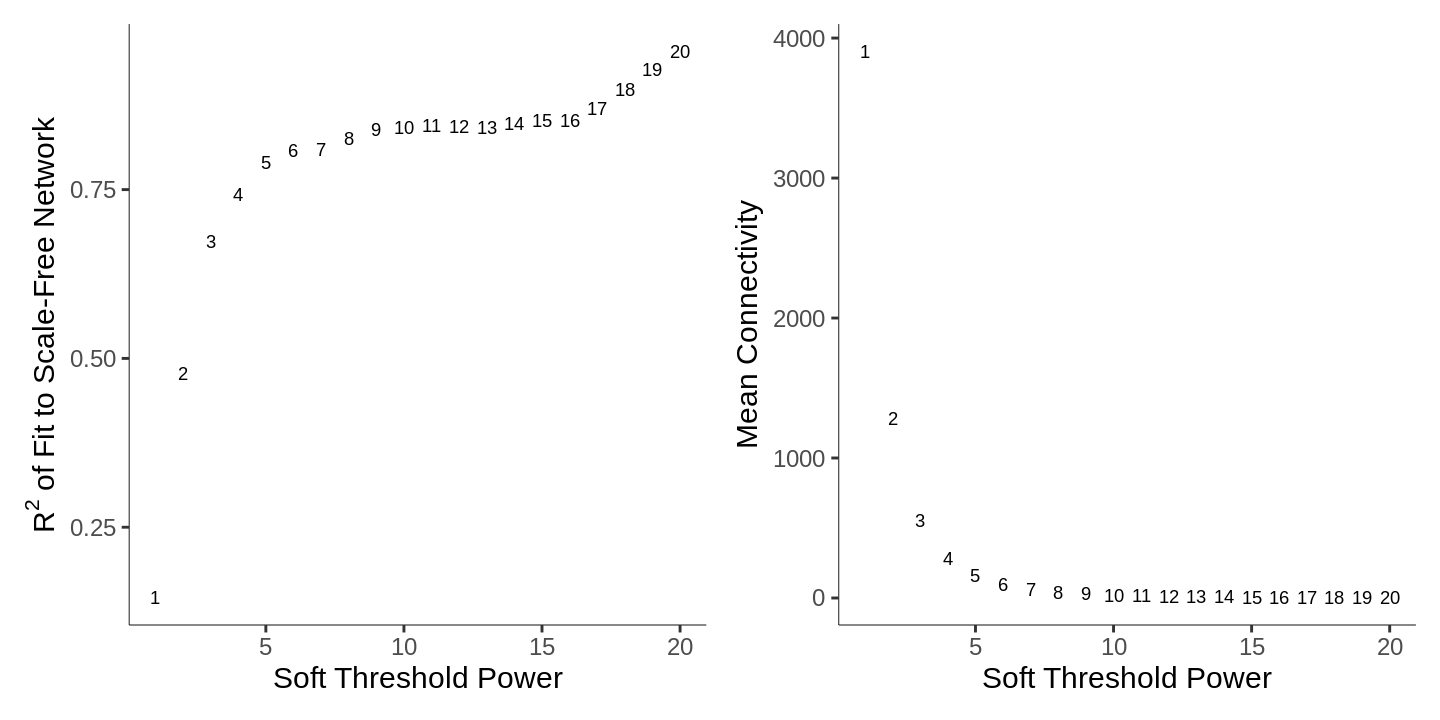

In [6]:
options(repr.plot.width=12, repr.plot.height=6)

p1 <- soft.thresholds$fitIndices %>%
    ggplot() +
    geom_text(aes(x=Power, y=SFT.R.sq, label=Power)) +
    xlab("Soft Threshold Power") + ylab(bquote(R^2*" of Fit to Scale-Free Network")) +
    ggplot_theme

p2 <- soft.thresholds$fitIndices %>%
    ggplot() +
    geom_text(aes(x=Power, y=mean.k., label=Power)) +
    xlab("Soft Threshold Power") + ylab("Mean Connectivity") +
    ggplot_theme

p1 + p2

In [7]:
print(soft.threshold.cap)

[1] 15


### Adjacency and TOM Matrices

The adjacency matrix defines the similarity between all genes in the sample data. I am using the [biweight midcorrelation](https://en.wikipedia.org/wiki/Biweight_midcorrelation) (`bicor`) function to estimate similarity. It is a median-based approach that is less sensitive to outliers.

I use $\beta=15$ for the scaling function, which was determined in the previous step. Then, the topological overlap metric (TOM) matrix is generated from the adjacency matrix. For details, check the original WGCNA paper.

In [8]:
adjacency.matrix = adjacency(
    gene.exp.cap, type="unsigned", 
    corFnc=bicor, corOptions=list(use="pairwise.complete.obs", pearsonFallback="none"), 
    power=soft.threshold.cap
)

TOM.cap.matrix = TOMsimilarity(adjacency.matrix)

dir.create("~/gains_team282/nikhil/expression/gene_expression/", recursive=TRUE)
saveRDS(TOM.cap.matrix, file="~/gains_team282/nikhil/expression/gene_expression/TOM.cap.matrix.RDS")

TOM.cap.dist = 1 - TOM.cap.matrix

Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Some results will be NA.”


..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


Warning message in dir.create("~/gains_team282/nikhil/expression/gene_expression/", :
“'/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/gene_expression' already exists”


### Clustering TOM Matrix

The gene co-expression modules are generated by clustering the TOM matrix.

 ..cutHeight not given, setting it to 0.999  ===>  99% of the (truncated) height range in dendro.
 ..done.


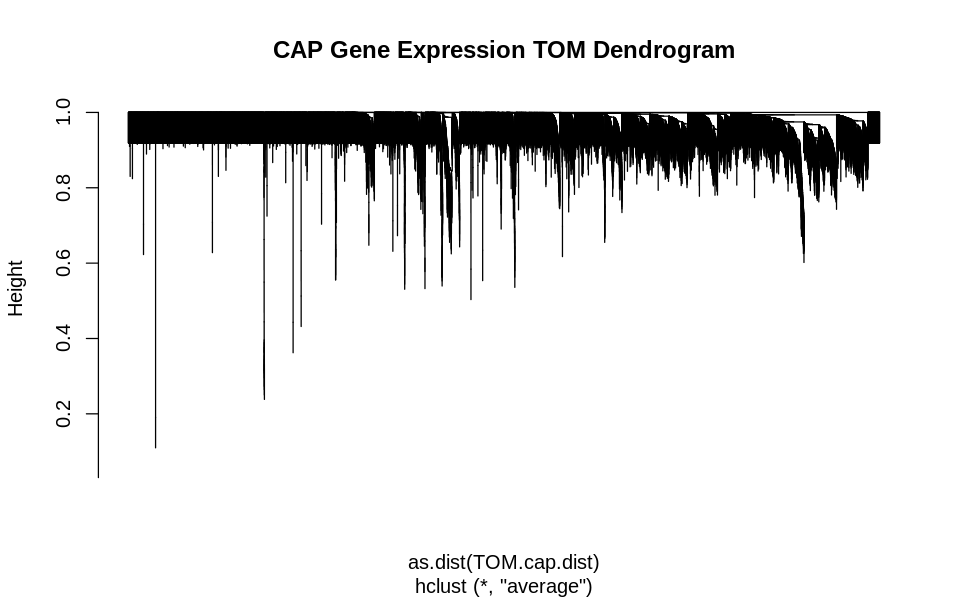

In [9]:
dendrogram = hclust(as.dist(TOM.cap.dist), method="average")

options(repr.plot.width=8, repr.plot.height=5)

plot(dendrogram, labels=FALSE, main="CAP Gene Expression TOM Dendrogram")

dynamic.mods.cap = cutreeDynamic(
  dendro=dendrogram, distM=TOM.cap.dist, pamRespectsDendro=FALSE,
  minClusterSize = 10
)
rm(TOM.cap.dist)

### Intra- and Inter-Module Connectivity

Connectivity is a measure assigned to each gene that describes how well the gene fits into a certain group of genes. Intra-module connectivity is a measure of how well the gene belongs to the module, Conversely, inter-module connectivity is a measure of how well the gene belongs to all other genes outside the module. Genes that are more "central" in the module will tend to have a high intra-module connectivity and a low inter-module connectivity.

In [10]:
connectivity.cap <- intramodularConnectivity(TOM.cap.matrix, colors=dynamic.mods.cap)
rownames(connectivity.cap) <- colnames(gene.exp.cap)

### Co-Expression Module Size Distribution

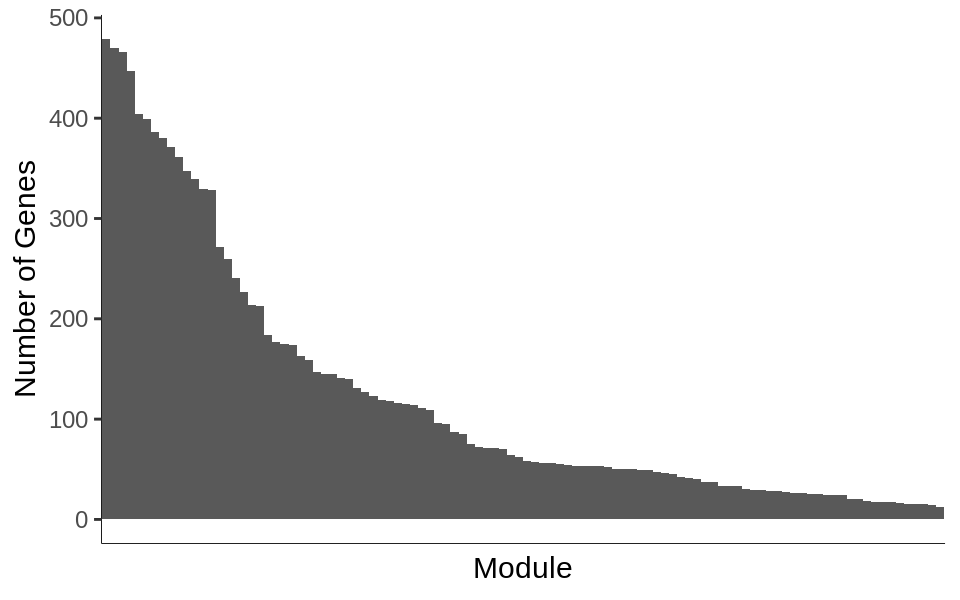

In [11]:
plot.data <- as.data.frame(table(dynamic.mods.cap)) %>%
  dplyr::select(Module=1, Frequency=Freq) %>%
  dplyr::filter(Module != 0)

options(repr.plot.width=8, repr.plot.height=5)

ggplot(plot.data) +
  geom_col(aes(x=Module, y=Frequency), width=1) +
  xlab("Module") + ylab("Number of Genes") +
  ggplot_theme +
  theme(axis.text.x=element_blank(), axis.ticks.x=element_blank())
ggsave(filename="04_Expression/results/gene_coexpression_module_sizes_cap.svg", width=8, height=5)

### Save Gene Co-Expression Modules

I save a the list of genes and their assigned modules, the eigengenes, the variance explained by each eigengene, and the connectivity information for each gene.

The modules are labelled `Module_1,Module_2,...`. `Module_0` contains genes that were not assigned to any co-expression module by WGCNA and are therefore labelled as `Unassigned`.

The eigengene of a given co-expression module is the first principal component of the gene expression for the genes within the module.

The variance explained by each eigengene tells us how well the eigengene captures the overall variation found within the module expression data.

In [12]:
### Module Assignment

gene.list <- colnames(gene.exp.cap)

mod.assignment <- dynamic.mods.cap
mod.labels <- paste0("Module_", mod.assignment)
mod.labels[mod.labels == "Module_0"] <- "Unassigned"

modules <- data.frame(
  Gene=gene.list,
  Module=mod.labels
) %>%
  dplyr::arrange(Module, Gene)

write.csv(modules, "~/gains_team282/nikhil/expression/gene_expression/modules.cap.csv", row.names=F)

### Eigengenes

eigengenes.result <- moduleEigengenes(gene.exp.cap[mod.labels != "Unassigned"], colors=mod.labels[mod.labels != "Unassigned"])
eigengene.order <- order(as.numeric(sapply(strsplit(colnames(eigengenes.result$eigengenes), "_"), function(x) x[2])))

eigengenes <- eigengenes.result$eigengenes
colnames(eigengenes) <- sapply(strsplit(colnames(eigengenes), "_"), function(x) paste0("ME_", x[2]))
eigengenes <- eigengenes[,eigengene.order]

rownames(eigengenes) <- rownames(gene.exp.cap)

write.csv(eigengenes, "~/gains_team282/nikhil/expression/gene_expression/eigengenes.cap.csv")

variance.explained <- data.frame(
  Module=colnames(eigengenes),
  Var.Explained=t(eigengenes.result$varExplained[eigengene.order])[,1]
)

write.csv(variance.explained, "~/gains_team282/nikhil/expression/gene_expression/variance.explained.cap.csv", row.names=F)

### Connectivity

connectivity <- connectivity.cap[modules$Gene,]
connectivity <- cbind(connectivity, modules$Module)
colnames(connectivity)[ncol(connectivity)] <- "Module"

write.csv(connectivity, "~/gains_team282/nikhil/expression/gene_expression/connectivity.cap.csv")

# Remove files used in CAP analysis to clear up space for FP analysis
rm(
  connectivity, connectivity.cap, dendrogram, eigengenes, eigengenes.result, 
  modules, plot.data, TOM.cap.matrix, variance.explained
)

## FP Individuals

The following analysis generates co-expression modules from gene expression from individuals with fecal peritonitis (FP).

### WGCNA Checks

The following function identifies genes with excessive missing values and outlier samples. It is generally more important for microarray data.

In [13]:
gsg <- goodSamplesGenes(gene.exp.fp)
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

### Soft Threshold

The adjacency matrix generated using the correlation function does not fit a scale-free topology. A scaling function is used to generate the appropriate gene degree distribution. A parameter of this scaling function, $\beta$, is estimated by trying multiple values and checking how well the resulting network fits the assumptions of a scale-free network. Here, I try all integer values in $[1,20]$.

In [14]:
powers = seq(1, 20, by=1)

soft.thresholds = pickSoftThreshold(gene.exp.fp, powerVector=powers, networkType="unsigned", corFnc=bicor)

soft.threshold.fp = soft.thresholds$powerEstimate

Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for ind

   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1    0.123  0.581          0.922 3720.00  3.66e+03   6640
2      2    0.459 -0.802          0.907 1160.00  1.02e+03   3180
3      3    0.707 -1.260          0.922  475.00  3.66e+02   1880
4      4    0.772 -1.460          0.938  233.00  1.50e+02   1240
5      5    0.811 -1.560          0.955  129.00  6.84e+01    882
6      6    0.826 -1.630          0.960   77.70  3.33e+01    659
7      7    0.832 -1.670          0.961   50.00  1.71e+01    509
8      8    0.834 -1.680          0.962   33.90  9.06e+00    403
9      9    0.838 -1.660          0.959   24.00  4.97e+00    325
10    10    0.840 -1.630          0.949   17.60  2.80e+00    266
11    11    0.832 -1.600          0.922   13.20  1.62e+00    221
12    12    0.824 -1.530          0.883   10.20  9.59e-01    185
13    13    0.957 -1.360          0.967    8.09  5.80e-01    157
14    14    0.979 -1.350          0.986    6.51  3.56e-01    145
15    15    0.982 -1.360 

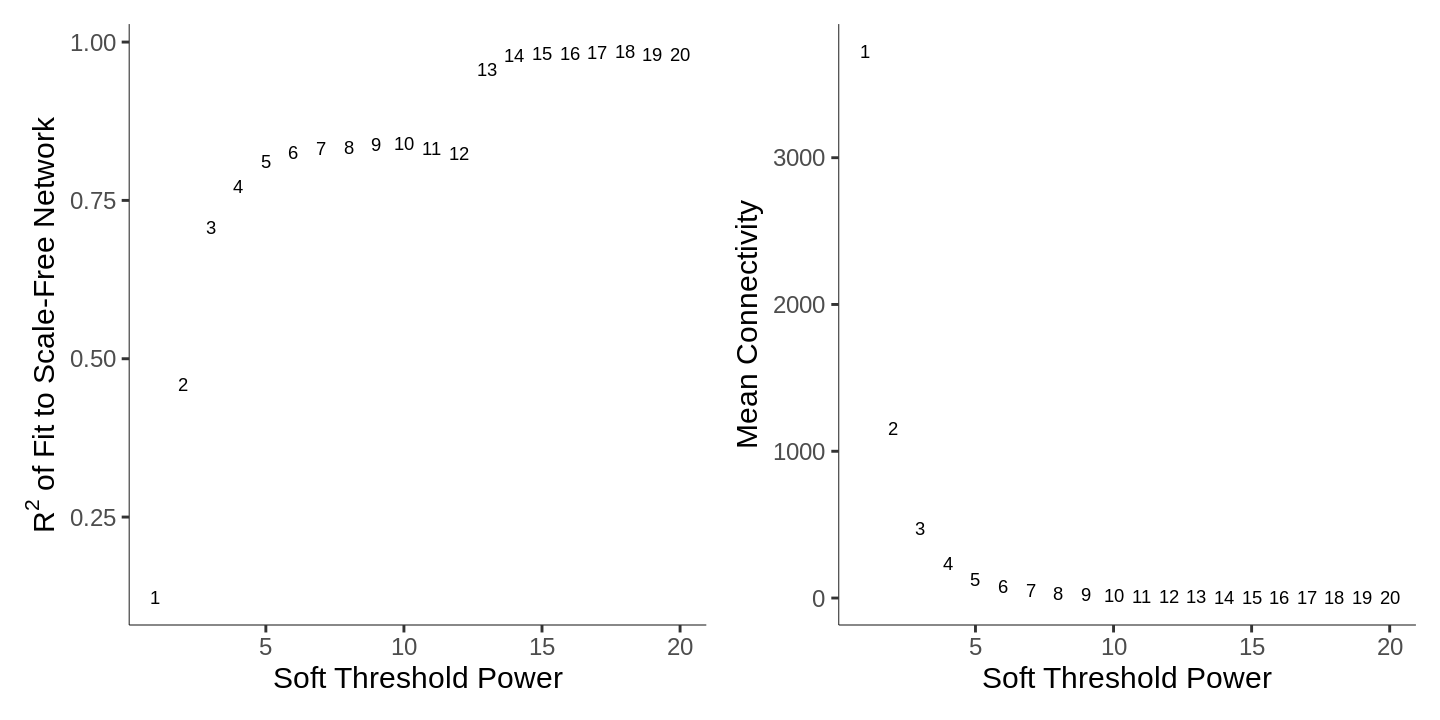

In [15]:
options(repr.plot.width=12, repr.plot.height=6)

p1 <- soft.thresholds$fitIndices %>%
    ggplot() +
    geom_text(aes(x=Power, y=SFT.R.sq, label=Power)) +
    xlab("Soft Threshold Power") + ylab(bquote(R^2*" of Fit to Scale-Free Network")) +
    ggplot_theme

p2 <- soft.thresholds$fitIndices %>%
    ggplot() +
    geom_text(aes(x=Power, y=mean.k., label=Power)) +
    xlab("Soft Threshold Power") + ylab("Mean Connectivity") +
    ggplot_theme

p1 + p2

In [16]:
print(soft.threshold.fp)

[1] 13


### Adjacency and TOM Matrices

The adjacency matrix defines the similarity between all genes in the sample data. I am using the [biweight midcorrelation](https://en.wikipedia.org/wiki/Biweight_midcorrelation) (`bicor`) function to estimate similarity. It is a median-based approach that is less sensitive to outliers.

I use $\beta=13$ for the scaling function, which was determined in the previous step. Then, the topological overlap metric (TOM) matrix is generated from the adjacency matrix. For details, check the original WGCNA paper.

In [17]:
adjacency.matrix = adjacency(
    gene.exp.fp, type="unsigned", 
    corFnc=bicor, corOptions=list(use="pairwise.complete.obs", pearsonFallback="none"), 
    power=soft.threshold.fp
)

TOM.fp.matrix = TOMsimilarity(adjacency.matrix)

dir.create("~/gains_team282/nikhil/expression/gene_expression/", recursive=TRUE)
saveRDS(TOM.fp.matrix, file="~/gains_team282/nikhil/expression/gene_expression/TOM.fp.matrix.RDS")

TOM.fp.dist = 1 - TOM.fp.matrix

Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Some results will be NA.”


..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


Warning message in dir.create("~/gains_team282/nikhil/expression/gene_expression/", :
“'/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/gene_expression' already exists”


### Clustering TOM Matrix

The gene co-expression modules are generated by clustering the TOM matrix.

 ..cutHeight not given, setting it to 0.999  ===>  99% of the (truncated) height range in dendro.
 ..done.


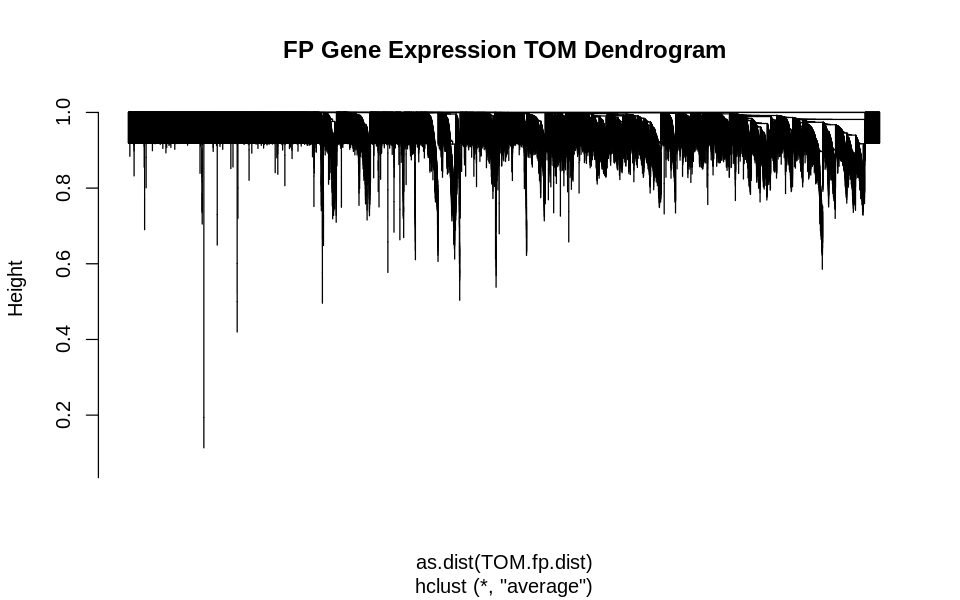

In [18]:
dendrogram = hclust(as.dist(TOM.fp.dist), method="average")

options(repr.plot.width=8, repr.plot.height=5)

plot(dendrogram, labels=FALSE, main="FP Gene Expression TOM Dendrogram")

dynamic.mods.fp = cutreeDynamic(
  dendro=dendrogram, distM=TOM.fp.dist, pamRespectsDendro=FALSE,
  minClusterSize = 10
)
rm(TOM.fp.dist)

### Intra- and Inter-Module Connectivity

Connectivity is a measure assigned to each gene that describes how well the gene fits into a certain group of genes. Intra-module connectivity is a measure of how well the gene belongs to the module, Conversely, inter-module connectivity is a measure of how well the gene belongs to all other genes outside the module. Genes that are more "central" in the module will tend to have a high intra-module connectivity and a low inter-module connectivity.

In [19]:
connectivity.fp <- intramodularConnectivity(TOM.fp.matrix, colors=dynamic.mods.fp)
rownames(connectivity.fp) <- colnames(gene.exp.fp)

### Co-Expression Module Size Distribution

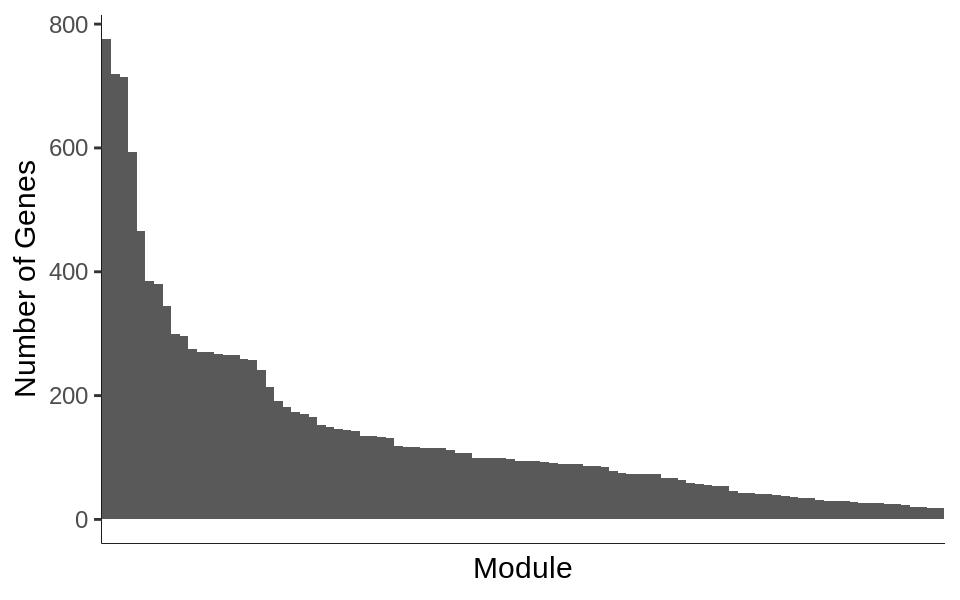

In [20]:
plot.data <- as.data.frame(table(dynamic.mods.fp)) %>%
  dplyr::select(Module=1, Frequency=Freq) %>%
  dplyr::filter(Module != 0)

options(repr.plot.width=8, repr.plot.height=5)

ggplot(plot.data) +
  geom_col(aes(x=Module, y=Frequency), width=1) +
  xlab("Module") + ylab("Number of Genes") +
  ggplot_theme +
  theme(axis.text.x=element_blank(), axis.ticks.x=element_blank())
ggsave(filename="04_Expression/results/gene_coexpression_module_sizes_fp.svg", width=8, height=5)

### Save Gene Co-Expression Modules

I save a the list of genes and their assigned modules, the eigengenes, the variance explained by each eigengene, and the connectivity information for each gene.

The modules are labelled `Module_1,Module_2,...`. `Module_0` contains genes that were not assigned to any co-expression module by WGCNA and are therefore labelled as `Unassigned`.

The eigengene of a given co-expression module is the first principal component of the gene expression for the genes within the module.

The variance explained by each eigengene tells us how well the eigengene captures the overall variation found within the module expression data.

In [21]:
### Module Assignment

gene.list <- colnames(gene.exp.fp)

mod.assignment <- dynamic.mods.fp
mod.labels <- paste0("Module_", mod.assignment)
mod.labels[mod.labels == "Module_0"] <- "Unassigned"

modules <- data.frame(
  Gene=gene.list,
  Module=mod.labels
) %>%
  dplyr::arrange(Module, Gene)

write.csv(modules, "~/gains_team282/nikhil/expression/gene_expression/modules.fp.csv", row.names=F)

### Eigengenes

eigengenes.result <- moduleEigengenes(gene.exp.fp[mod.labels != "Unassigned"], colors=mod.labels[mod.labels != "Unassigned"])
eigengene.order <- order(as.numeric(sapply(strsplit(colnames(eigengenes.result$eigengenes), "_"), function(x) x[2])))

eigengenes <- eigengenes.result$eigengenes
colnames(eigengenes) <- sapply(strsplit(colnames(eigengenes), "_"), function(x) paste0("ME_", x[2]))
eigengenes <- eigengenes[,eigengene.order]

rownames(eigengenes) <- rownames(gene.exp.fp)

write.csv(eigengenes, "~/gains_team282/nikhil/expression/gene_expression/eigengenes.fp.csv")

variance.explained <- data.frame(
  Module=colnames(eigengenes),
  Var.Explained=t(eigengenes.result$varExplained[eigengene.order])[,1]
)

write.csv(variance.explained, "~/gains_team282/nikhil/expression/gene_expression/variance.explained.fp.csv", row.names=F)

### Connectivity

connectivity <- connectivity.fp[modules$Gene,]
connectivity <- cbind(connectivity, modules$Module)
colnames(connectivity)[ncol(connectivity)] <- "Module"

write.csv(connectivity, "~/gains_team282/nikhil/expression/gene_expression/connectivity.fp.csv")